In [11]:
item_nm = '무'

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost.callback import EarlyStopping
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

df = pd.read_csv(f"../data/{item_nm}_월차_작년평균단가포함.csv", encoding="cp949")
df = df.drop(columns=["등급코드"], errors="ignore")
df["week_start"] = pd.to_datetime(df["week_start"])
df = df.sort_values("week_start")

group_cols = ["직팜산지코드"]

df["평균단가_직전주"] = df.groupby(group_cols)["평균단가(원)"].shift(1)
df["target_ratio"] = (df["평균단가(원)"] - df["평균단가_직전주"]) / df["평균단가_직전주"]

df["week_sin"] = np.sin(2 * np.pi * df["week"] / 52)
df["week_cos"] = np.cos(2 * np.pi * df["week"] / 52)
df["연속주차"] = (df["year"] - df["year"].min()) * 52 + df["week"]
df["연도경과"] = df["year"] - df["year"].min()

df["총거래량_lag1"] = df.groupby(group_cols)["총거래량(kg)"].shift(1)
df["총거래량_변화율"] = (df["총거래량(kg)"] - df["총거래량_lag1"]) / df["총거래량_lag1"]
df["총거래량_전년"] = df.groupby(group_cols)["총거래량(kg)"].shift(52)
df["총거래량_전년비"] = (df["총거래량(kg)"] - df["총거래량_전년"]) / df["총거래량_전년"]

for t in range(1, 6):
    df[f"평균단가_t-{t}"] = df.groupby(group_cols)["평균단가(원)"].shift(t)

for w in [2, 3, 4]:
    df[f"평균단가_직전{w}주평균"] = df[[f"평균단가_t-{i}" for i in range(1, w+1)]].mean(axis=1)
    df[f"평균단가_직전{w}주표준편차"] = df[[f"평균단가_t-{i}" for i in range(1, w+1)]].std(axis=1)

for t in range(2, 5):
    df[f"단가_변화율_t-{t}"] = (df[f"평균단가_t-{t-1}"] - df[f"평균단가_t-{t}"]) / df[f"평균단가_t-{t}"]
df["단가_가속도"] = df["단가_변화율_t-2"] - df["단가_변화율_t-3"]

df["작년평균단가_전주"] = df.groupby(group_cols)["작년평균단가(원)"].shift(1)
df["작년평균단가_변화율"] = (df["작년평균단가(원)"] - df["작년평균단가_전주"]) / df["작년평균단가_전주"]

In [12]:
features = [
    "week_sin", "week_cos", "연속주차", "연도경과",
    "총거래량(kg)", "총거래량_변화율", "총거래량_전년비",
    "작년평균단가(원)", "작년평균단가_변화율",
    "단가_가속도"
] + \
[f"평균단가_t-{i}" for i in range(1, 6)] + \
[f"평균단가_직전{w}주평균" for w in [2, 3, 4]] + \
[f"평균단가_직전{w}주표준편차" for w in [2, 3, 4]]

df_train = df[(df["year"] >= 2019) & (df["year"] <= 2024)]
df_train = df_train.dropna(subset=["target_ratio"] + features).copy()

le = LabelEncoder()
df_train["직팜산지코드_le"] = le.fit_transform(df_train["직팜산지코드"])

X = df_train[features].astype(np.float32)
y = df_train["target_ratio"]

split_date = df_train["week_start"].quantile(0.8)
X_train = X[df_train["week_start"] <= split_date]
X_val = X[df_train["week_start"] > split_date]
y_train = y[df_train["week_start"] <= split_date]
y_val = y[df_train["week_start"] > split_date]

scale_cols = ["총거래량(kg)", "총거래량_변화율", "총거래량_전년비", "작년평균단가_변화율"]
scaler = ColumnTransformer([("scale", RobustScaler(), scale_cols)], remainder="passthrough")
pipe = Pipeline([("scale", scaler)])
X_train_scaled = pipe.fit_transform(X_train)
X_val_scaled = pipe.transform(X_val)

In [13]:
from sklearn.ensemble import RandomForestRegressor # RandomForestRegressor 라이브러리 추가

model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=7,
    max_samples=0.8,         # subsample과 유사 (부트스트랩 시 샘플 비율)
    max_features=0.8,        # colsample_bytree와 유사 (피처 선택 비율)
    min_samples_leaf=1,      # min_child_weight와 유사 (리프 노드의 최소 샘플 수)
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val_scaled)))
mae = mean_absolute_error(y_val, model.predict(X_val_scaled))
r2 = r2_score(y_val, model.predict(X_val_scaled))
nmae = mae / np.mean(np.abs(y_val))

print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")
print(f"NMAE : {nmae:.4f}")


✅ 검증 성능:
RMSE : 1.4362
MAE  : 0.4041
R²   : 0.8123
NMAE : 0.5974


In [14]:
start_date = df[(df['year'] == 2024) & (df['week'] == 23)]["week_start"].min()
end_date = df[(df['year'] == 2025) & (df['week'] == 22)]["week_start"].max()
df_test = df[(df["week_start"] >= start_date) & (df["week_start"] <= end_date)].copy()

df_test["실제값"] = df_test["평균단가(원)"]
for col in features:
    if col not in df_test.columns:
        df_test[col] = np.nan

df_test = df_test[df_test["직팜산지코드"].isin(le.classes_)].copy()
df_test["직팜산지코드_le"] = le.transform(df_test["직팜산지코드"])
X_test = df_test[features].astype(np.float32)
X_test = X_test.dropna()
df_test = df_test.loc[X_test.index].copy()
X_test_scaled = pipe.transform(X_test)
y_pred_ratio = model.predict(X_test_scaled)
df_test["예측_변동률"] = y_pred_ratio
df_test["예측값"] = df_test["평균단가_t-1"] * (1 + df_test["예측_변동률"])

if "실제값" in df_test.columns:
    y_true = df_test["실제값"].values
    y_pred = df_test["예측값"].values


📊 2025년 테스트셋 성능:
✅ RMSE (test): 332.05
✅ MAE  (test): 248.39
✅ R²   (test): 0.2214
✅ NMAE (test): 0.2950


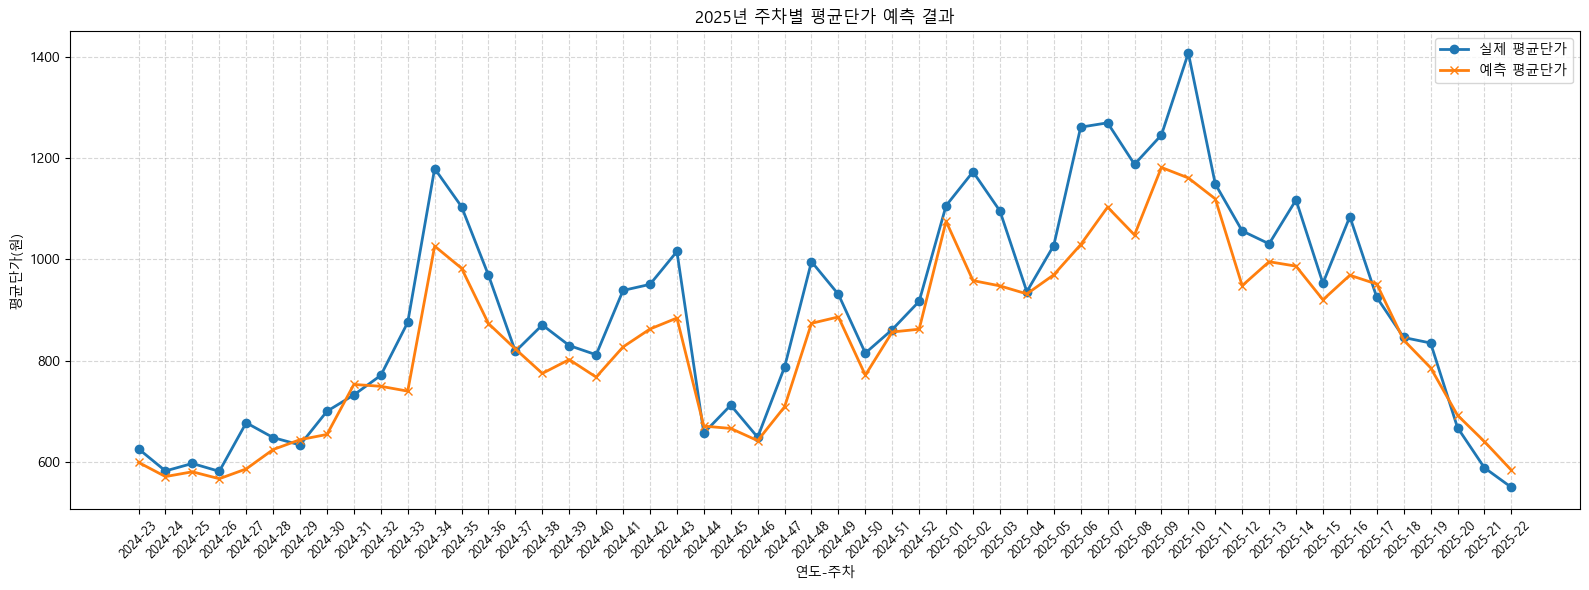

In [15]:
plot_df = df_test.reset_index(drop=True)
plot_df["year"] = plot_df["year"].astype(int)
plot_df["week"] = plot_df["week"].astype(int)
weekly_avg = (
    plot_df.groupby(["year", "week"])[["실제값", "예측값"]]
    .mean()
    .reset_index()
)
weekly_avg["연도_주차"] = weekly_avg["year"].astype(str) + "-" + weekly_avg["week"].astype(str).str.zfill(2)
plt.figure(figsize=(16, 6))
plt.plot(weekly_avg["연도_주차"], weekly_avg["실제값"], label="실제 평균단가", marker="o", linewidth=2)
plt.plot(weekly_avg["연도_주차"], weekly_avg["예측값"], label="예측 평균단가", marker="x", linewidth=2)
plt.title("2025년 주차별 평균단가 예측 결과")
plt.xlabel("연도-주차")
plt.ylabel("평균단가(원)")
plt.xticks(rotation=45, fontsize=9)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
df_test.columns

Index(['year', 'week', 'week_start', '품종코드', '직팜산지코드', '총거래량(kg)', '일평균기온',
       '최고기온', '최저기온', '평균상대습도', '강수량(mm)', '1시간최고강수량(mm)', '평균단가(원)',
       '작년평균단가(원)', '일평균기온_t-1', '최고기온_t-1', '최저기온_t-1', '평균상대습도_t-1',
       '강수량(mm)_t-1', '1시간최고강수량(mm)_t-1', '일평균기온_t-2', '최고기온_t-2', '최저기온_t-2',
       '평균상대습도_t-2', '강수량(mm)_t-2', '1시간최고강수량(mm)_t-2', '일평균기온_t-3',
       '최고기온_t-3', '최저기온_t-3', '평균상대습도_t-3', '강수량(mm)_t-3', '1시간최고강수량(mm)_t-3',
       'holiday_flag', 'holiday_score', 'grow_score', '작년평균단가(원).1',
       '평균단가_직전주', 'target_ratio', 'week_sin', 'week_cos', '연속주차', '연도경과',
       '총거래량_lag1', '총거래량_변화율', '총거래량_전년', '총거래량_전년비', '평균단가_t-1', '평균단가_t-2',
       '평균단가_t-3', '평균단가_t-4', '평균단가_t-5', '평균단가_직전2주평균', '평균단가_직전2주표준편차',
       '평균단가_직전3주평균', '평균단가_직전3주표준편차', '평균단가_직전4주평균', '평균단가_직전4주표준편차',
       '단가_변화율_t-2', '단가_변화율_t-3', '단가_변화율_t-4', '단가_가속도', '작년평균단가_전주',
       '작년평균단가_변화율', '실제값', '직팜산지코드_le', '예측_변동률', '예측값'],
      dtype='object')